In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
from itertools import chain
import pydicom
import os

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
len(sample_df[sample_df["Finding Labels"]=="Pneumonia"])

14

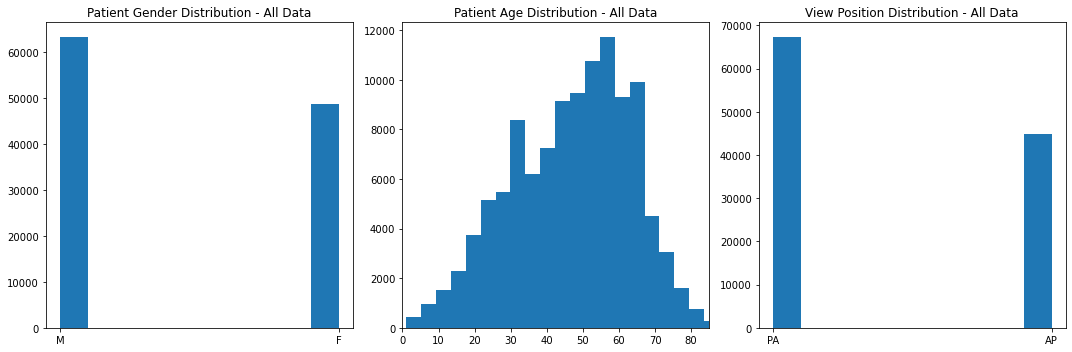

In [44]:
## EDA
# Todo 
# Plot demogrpahics for all patients in dataset
fig,a = plt.subplots(1,3, figsize=(15,5))
a = a.ravel()


a[0].hist(all_xray_df["Patient Gender"])
a[0].set_title("Patient Gender Distribution - All Data")

a[1].hist(all_xray_df["Patient Age"], bins=100)
a[1].set_title("Patient Age Distribution - All Data")
a[1].set_xlim([0,85])

a[2].hist(all_xray_df["View Position"])
a[2].set_title("View Position Distribution - All Data")

plt.tight_layout()


In [3]:
# split up labels so that I have one column in my dataframe per disease
d = all_xray_df.copy()
all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        

        
d3 = sample_df.copy()
all_labels = np.unique(list(chain(*d3['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d3[c_label] = d3['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


0.012763110952550838

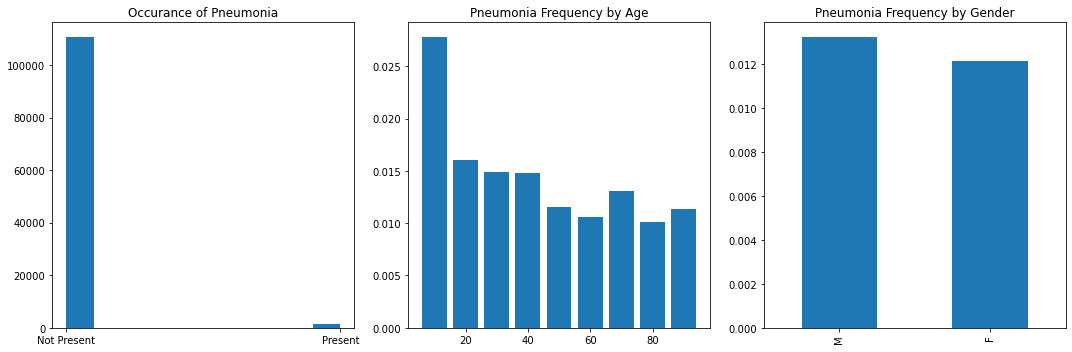

In [4]:
# Plot demogrpahics for only patients with Pneumonia

fig,a = plt.subplots(1,3, figsize=(15,5))
a = a.ravel()

d2 = d.copy()
d2["Pneumonia"] = d["Pneumonia"].replace([0.0, 1.0], ["Not Present", "Present"])

a[0].hist(d2["Pneumonia"])
a[0].set_title("Occurance of Pneumonia")


ages = [10,20,30,40,50,60,70,80,90]
rates = []
rates.append(len(d[(d["Pneumonia"] == 1) & (d["Patient Age"] < 10)])/len(d[(d["Patient Age"] < 10)]))
for i in range(1,9):
    r = i*10
    rates.append(len(d[(d["Pneumonia"] == 1) & (d["Patient Age"] >= r) & (d["Patient Age"] < (r+10))])/len(d[(d["Patient Age"] >= r) & (d["Patient Age"] < (r+10))]))
    

a[1].bar(ages, rates, width=8)
a[1].set_title("Pneumonia Frequency by Age")
#a[1].set_xlim([0,85])
#a[1].set_ylim([0,.05])

#a[2].hist((d[d["Pneumonia"] == 1]["Patient Gender"].value_counts())/(d["Patient Gender"].value_counts()))
series = (d[d["Pneumonia"] == 1]["Patient Gender"].value_counts())/(d["Patient Gender"].value_counts())
series.plot.bar(ax=a[2])
a[2].set_title("Pneumonia Frequency by Gender")

plt.tight_layout()



PA    0.600339
AP    0.399661
Name: View Position, dtype: float64

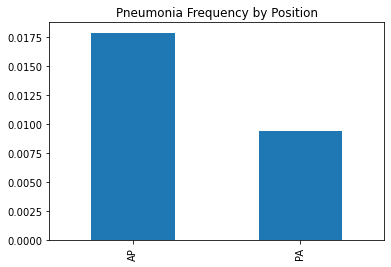

In [9]:
s = (d[d["Pneumonia"] == 1]["View Position"].value_counts())/(d["View Position"].value_counts())
s.plot.bar(title="Pneumonia Frequency by Position")

s2 = (d["View Position"].value_counts())/(len(d))
s2

(-0.5, 6.5)

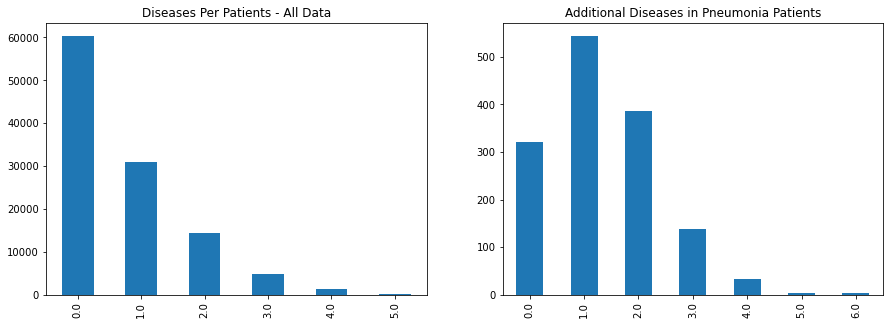

In [31]:
#figure out number of diseases per patient

col_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
d['Disease Count'] = d[col_list].sum(axis=1)

fig2,b = plt.subplots(1,2, figsize=(15,5))
b = b.ravel()

diseases = d['Disease Count'].value_counts()
diseases.plot.bar(ax=b[0])
b[0].set_title("Diseases Per Patients - All Data")
b[0].set_xlim([-0.5,5.5])

col_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']
d['Additional Disease Count'] = d[col_list].sum(axis=1)

diseases2 = d[d["Pneumonia"] == 1]['Additional Disease Count'].value_counts()
diseases2 = diseases2.reindex(index = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
diseases2.plot.bar(ax=b[1])
b[1].set_title("Additional Diseases in Pneumonia Patients")
b[1].set_xlim([-0.5,6.5])


Text(0.5, 1.0, 'Diseases Comorbid with Pneumonia')

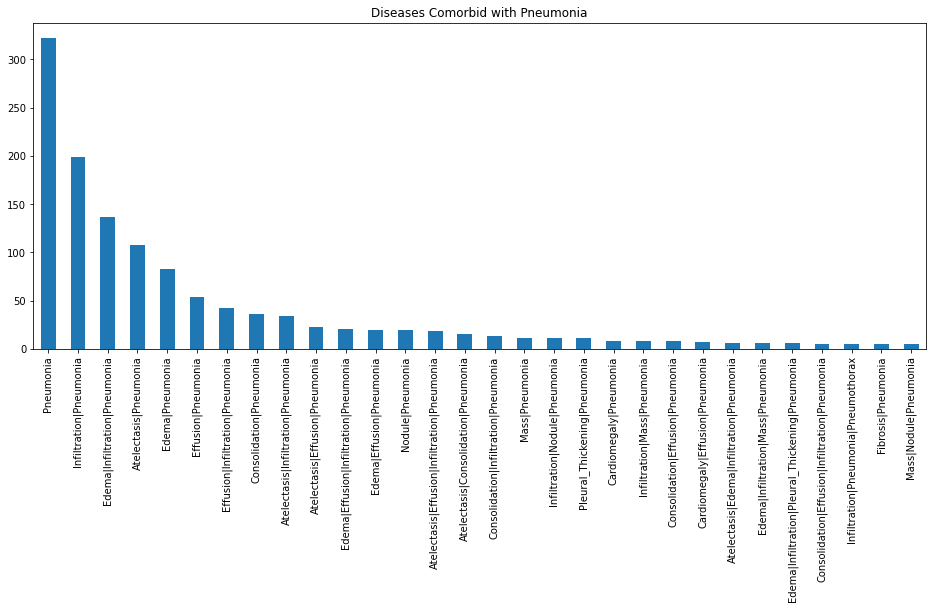

In [33]:
plt.figure(figsize=(16,6))

ax = d[d.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
ax.set_title("Diseases Comorbid with Pneumonia")

Text(0.5, 1.0, 'Disease Distribution - All Data')

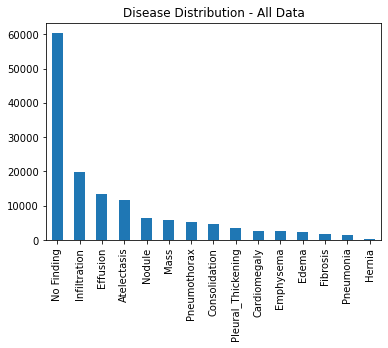

In [40]:
col_list = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
ax = d[col_list].sum(axis=0).sort_values(ascending=False).plot(kind="bar")
ax.set_title("Disease Distribution - All Data")

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
d3['path'] = d3['Image Index'].map(all_image_paths.get)
d3.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
5275,00028357_029.png,No Finding,29,28357,052Y,M,AP,2544,3056,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_012/images/00028357_029.png
1482,00007728_001.png,No Finding,1,7728,027Y,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_004/images/00007728_001.png
5194,00027726_050.png,Atelectasis|Infiltration,50,27726,058Y,M,AP,2544,3056,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_011/images/00027726_050.png
4117,00020289_000.png,No Finding,0,20289,064Y,M,PA,3056,2484,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_009/images/00020289_000.png
383,00001996_001.png,No Finding,1,1996,048Y,F,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_002/images/00001996_001.png


(0.0, 15000.0)

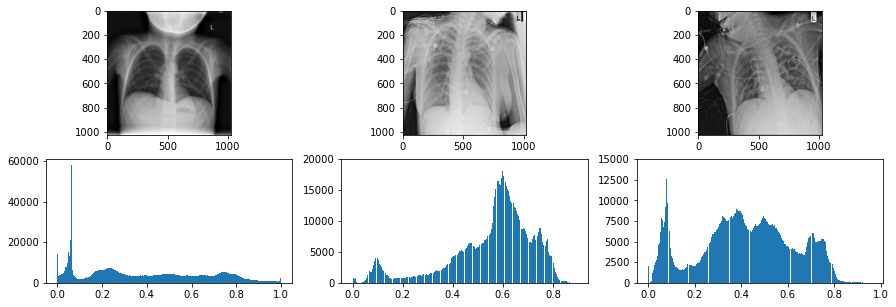

In [7]:



#Pneumonia Pixel Intensity Values

ims = d3[d3["Finding Labels"]=="Pneumonia"]

ims = ims.sample(5)

#pull Pneumonia 3 images AP positions
im1 = image.imread(ims.iloc[0]["path"])
im2 = image.imread(ims.iloc[1]["path"])
im3 = image.imread(ims.iloc[2]["path"])

#plt.figure(figsize=(5,5))
#plt.hist(im1.ravel(), bins = 256)
fig,a = plt.subplots(2,3, figsize=(15,5))
a = a.ravel()
a[0].imshow(im1,cmap='gray')
a[1].imshow(im2,cmap='gray')
a[2].imshow(im3,cmap='gray')
a[3].hist(im1.ravel(), bins = 256)
a[4].hist(im2.ravel(), bins = 256)
a[4].set_ylim([0,20000])
a[5].hist(im3.ravel(), bins = 256)
a[5].set_ylim([0,15000])

(0.0, 15000.0)

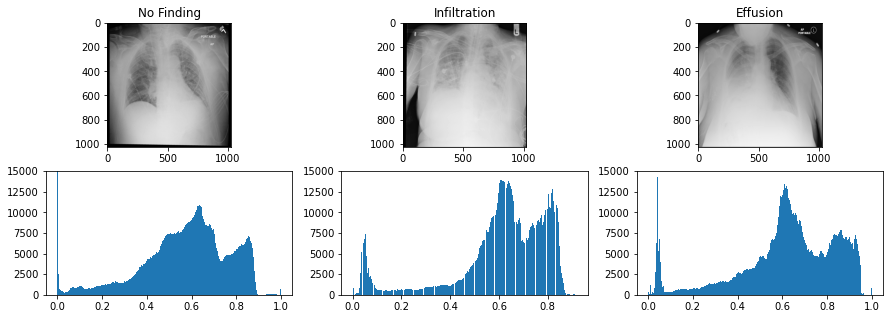

In [29]:
ims = d3[d3["Finding Labels"]=="Effusion"]


#no finding 
im1 = image.imread("/data/images_001/images/00000057_001.png")
#infiltration
im2 = image.imread("/data/images_001/images/00000181_035.png")
#Effusion
im3 = image.imread("/data/images_001/images/00000127_007.png")
ims

fig,a = plt.subplots(2,3, figsize=(15,5))
a = a.ravel()
a[0].imshow(im1,cmap='gray')
a[0].set_title("No Finding")
a[1].imshow(im2,cmap='gray')
a[1].set_title("Infiltration")
a[2].imshow(im3,cmap='gray')
a[2].set_title("Effusion")
a[3].hist(im1.ravel(), bins = 256)
a[3].set_ylim([0,15000])

a[4].hist(im2.ravel(), bins = 256)

a[4].set_ylim([0,15000])
a[5].hist(im3.ravel(), bins = 256)

a[5].set_ylim([0,15000])

(0.0, 15000.0)

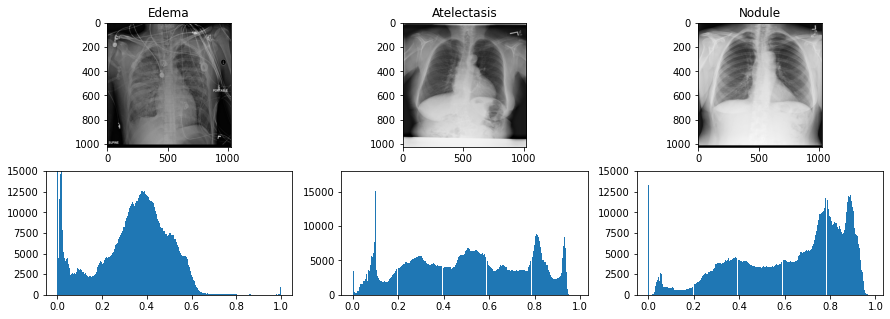

In [9]:
ims1 = d3[d3["Finding Labels"]=="Edema"]
ims2 = d3[d3["Finding Labels"]=="Atelectasis"]
ims3 = d3[d3["Finding Labels"]=="Nodule"]

ims1 = ims1.sample(1)
ims2 = ims2.sample(1)
ims3 = ims3.sample(1)

#pull Pneumonia 3 images AP positions
im1 = image.imread(ims1.iloc[0]["path"])
im2 = image.imread(ims2.iloc[0]["path"])
im3 = image.imread(ims3.iloc[0]["path"])


fig,a = plt.subplots(2,3, figsize=(15,5))
a = a.ravel()
a[0].imshow(im1,cmap='gray')
a[0].set_title("Edema")
a[1].imshow(im2,cmap='gray')
a[1].set_title("Atelectasis")
a[2].imshow(im3,cmap='gray')
a[2].set_title("Nodule")
a[3].hist(im1.ravel(), bins = 256)
a[3].set_ylim([0,15000])

a[4].hist(im2.ravel(), bins = 256)

a[4].set_ylim([0,18000])
a[5].hist(im3.ravel(), bins = 256)

a[5].set_ylim([0,15000])

In [22]:
#Pixel Intensity Values Not approporate for use in training as intensity distributions of the classes can't be clearly separated. 


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,00030639_001.png,No Finding,1,30639,061Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5600,00030704_000.png,No Finding,0,30704,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
